Choose Resnet 152 because its suppose to be more accurate than the regular resnet. This enhancement is achieved by avoiding downsampling. In the regular ResNet, the downsampling is accomplished with a stride of 2 in the first 1x1 convolution, whereas in ResNet 1.5, the stride is implemented in the 3x3 convolution. Additionally, ResNet 152 has the advantage of having an existing implementation that utilizes image binaries instead of opening images directly, which was causing issues, particularly with large batch sizes leading to exponential label increases. This problem was successfully addressed, resulting in significant RAM savings.

In [ ]:
!pip install transformers
!pip install datasets

from google.colab import drive
import zipfile
import os
import h5py
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, ResNetForImageClassification
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import torch
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#reading in the zippe x_train, x_test files (too large to save as .h5) and unzipping them

zip_file_path = '/content/drive/MyDrive/x_train.zip'
extract_dir = '/content/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


zip_file_path = '/content/drive/MyDrive/x_test.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
#reading in all the .h5 files, now that we have unzipped the two that were zipped, and saving them as a list of strings to be worked on later

y_train_h5_path = '/content/drive/My Drive/y_train.h5'
y_test_h5_path = '/content/drive/My Drive/y_test.h5'

# Open the HDF5 file for reading
with h5py.File(y_train_h5_path, 'r') as hf:
    # Read the dataset
    y_train = hf['y_train'][:]
    # Convert the dataset to a list of strings
    y_train_list = [str(item, 'utf-8') for item in y_train]

# Open the HDF5 file for reading
with h5py.File(y_test_h5_path, 'r') as hf:
    # Read the dataset
    y_test = hf['y_test'][:]
    # Convert the dataset to a list of strings
    y_test_list = [str(item, 'utf-8') for item in y_test]

# Open the HDF5 file for reading
with h5py.File('x_train.h5', 'r') as hf:
    # Read the dataset
    x_train = hf['x_train'][:]

# Open the HDF5 file for reading
with h5py.File('x_test.h5', 'r') as hf:
    # Read the dataset
    x_test = hf['x_test'][:]

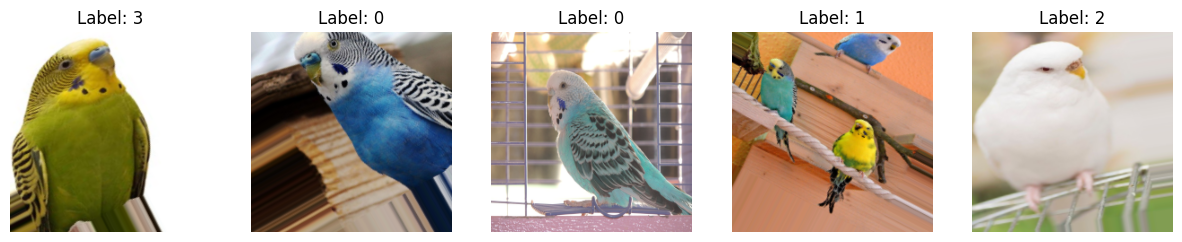

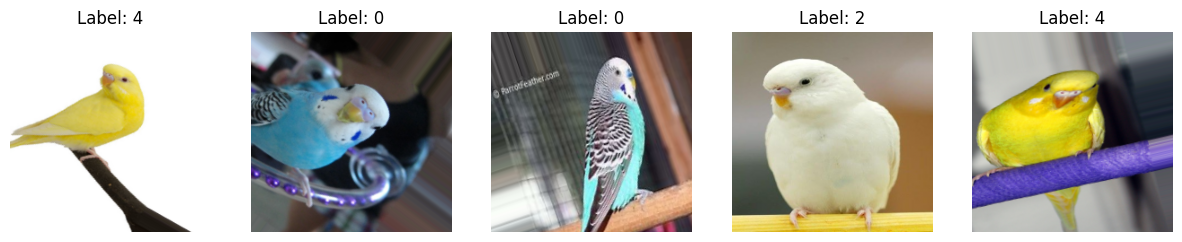

In [ ]:
#visualize image function from our phase 1 colab copied and pasted to be used in this colab

def visualize_images(images, labels):
    num_images = len(images)
    if num_images == 0:
        print("No images found in the HDF5 file.")
        return
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images[:5]):  # Visualize only the first 5 images
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Label: {}".format(labels[i]))
    plt.show()

visualize_images(x_test, y_test_list)
visualize_images(x_train, y_train_list)
# print(x_test)

In [ ]:
# Define the model name or path
#loading in our model and feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-152")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-152")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [ ]:
#this block is where we turn the list of strings into encoder objects for the y ones, and tensors for the x ones,
# we also split the read in data into validation and testing, since we had not done this previously but is necessary for the way we call trianing the model

y_train_strings = [str(label) for label in y_train]
y_train_strings = np.array(y_train_strings).reshape(-1, 1)

# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder on the list of strings
encoder.fit(y_train_strings)

# Transform the list of strings using the encoder
y_train_encoded = encoder.transform(y_train_strings)

# Convert the encoded data to a PyTorch tensor
y_train_tensor = torch.Tensor(y_train_encoded.toarray())

x_train_tensor = torch.Tensor(x_train)
# x_train_tesnor = torch.transpose(x_train_tensor, 1,3)
x_train_tensor = x_train_tensor.permute(0, 3, 1, 2)
# Convert one-hot encoded labels to class indices
y_train_indices = torch.argmax(y_train_tensor, dim=1)

# Splitting indices into train and validation sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(splitter.split(x_train_tensor, y_train_indices))

# Creating datasets and dataloaders for train and validation sets
train_dataset = TensorDataset(x_train_tensor[train_indices], y_train_indices[train_indices])
val_dataset = TensorDataset(x_train_tensor[val_indices], y_train_indices[val_indices])

# Create DataLoader instances for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

In [ ]:
#turning y_test, x_test into hot encoder and tensors for model

y_test_strings = [str(label) for label in y_test]
y_test_strings = np.array(y_test_strings).reshape(-1, 1)

# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder on the list of strings
encoder.fit(y_test_strings)

# Transform the list of strings using the encoder
y_test_encoded = encoder.transform(y_test_strings)

# Convert the encoded data to a PyTorch tensor
y_test_tensor = torch.Tensor(y_test_encoded.toarray())

x_test_tensor = torch.Tensor(x_test)
# x_test_tesnor = torch.transpose(x_test_tensor, 1,3)
x_test_tensor = x_test_tensor.permute(0, 3, 1, 2)
# Convert one-hot encoded labels to class indices
y_test_indices = torch.argmax(y_test_tensor, dim=1)

# Create a TensorDataset with class indices as labels
dataset = TensorDataset(x_test_tensor, y_test_indices)

# Create a DataLoader
test_dataloader = DataLoader(dataset, batch_size=50, shuffle=True)


In [ ]:
# Iterate over the first batch in the DataLoader
for batch in train_dataloader:
    # Unpack the batch into inputs and labels
    inputs, labels = batch

    # Print the shape of the inputs and labels
    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)

    # Optionally, print the first few elements of the inputs and labels
    print("First few elements of inputs:", inputs[:5])
    print("First few elements of labels:", labels[:5])

    # Break the loop after inspecting the first batch
    break


Input shape: torch.Size([50, 3, 224, 224])
Label shape: torch.Size([50])
First few elements of inputs: tensor([[[[9.2465e-01, 9.2505e-01, 9.2549e-01,  ..., 4.5182e-01,
           4.4685e-01, 4.4188e-01],
          [9.2241e-01, 9.2338e-01, 9.2549e-01,  ..., 3.0645e-01,
           3.0227e-01, 2.9809e-01],
          [9.2157e-01, 9.2278e-01, 9.2549e-01,  ..., 1.8874e-01,
           1.8625e-01, 1.8377e-01],
          ...,
          [5.4902e-02, 5.4902e-02, 5.4902e-02,  ..., 1.2941e-01,
           1.2941e-01, 1.2941e-01],
          [5.4902e-02, 5.4902e-02, 5.4902e-02,  ..., 1.2941e-01,
           1.2941e-01, 1.2941e-01],
          [5.4902e-02, 5.4902e-02, 5.4902e-02,  ..., 1.2941e-01,
           1.2941e-01, 1.2941e-01]],

         [[9.2073e-01, 9.2113e-01, 9.2157e-01,  ..., 6.6555e-01,
           6.6359e-01, 6.6163e-01],
          [9.1849e-01, 9.1945e-01, 9.2157e-01,  ..., 6.1033e-01,
           6.0916e-01, 6.0798e-01],
          [9.1765e-01, 9.1885e-01, 9.2157e-01,  ..., 5.8217e-01,
       

In [ ]:
labels = torch.flatten(labels)
print(labels)

tensor([4, 2, 2, 0, 1, 4, 3, 0, 0, 1, 1, 0, 0, 0, 3, 2, 3, 0, 2, 3, 2, 3, 1, 2,
        1, 1, 3, 1, 0, 0, 4, 0, 4, 0, 4, 1, 2, 1, 3, 4, 0, 0, 0, 2, 4, 2, 0, 0,
        4, 3])


In [ ]:
#Try these optimizers below and see which one is best

In [ ]:

#gradient accumulation is a way to train models with more data without taking up too much memory. images are passed through model and predictions are outputed
#the loss between predictions and actual labels is calculated, and the gradients are computed in relation using back propogation
#gradients are accumulated over a number of batchs, rather than updating the weights of the model immediately.
# Accumulation steps dictate how many batches are read in before updating the weights
#then weights are updated in model
#gradients are set to zero again for next round

# Define your optimizer and any other necessary components
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=.9)
#ones below NOT AS GOOD, focus on SGD and ADAM
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, alpha=.99, eps=1e-8, weight_decay=0, momentum=.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3, lr_decay=0, weight_decay=.01)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
#optimizer = torch.optim.Rprop(model.parameters(), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-6, 50))
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your training loop with gradient accumulation
def train_epoch(model, dataloader, optimizer, device, accumulation_steps):
    model.train()
    total_loss = 0.0 #initializing these numbers
    correct = 0
    total = 0
    accumulated_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(dataloader, desc="Training")): #flattening our lables and viewing them
        images, labels = images.to(device), labels.to(device)
        labels = torch.flatten(labels).long()
        labels = labels.view(-1)

        optimizer.zero_grad() #defining how optimizer works, clearing gradients
        outputs = model(images) #feeds model images for output to obtain models predictions

        if hasattr(outputs, 'logits'):
              outputs = outputs.logits

        loss = F.cross_entropy(outputs, labels) #calculates cross entropy loss
        loss.backward() #computes gradients of loss of predicted labels vs actual

        # Accumulate gradients
        accumulated_loss += loss.item() #accumalates loss over multiple batches for gradient accumulation

        if (i + 1) % accumulation_steps == 0:
            # Update parameters every accumulation_steps batches
            optimizer.step() #updates gradients, then clears them in the next line for next round
            optimizer.zero_grad()
            total_loss += accumulated_loss
            accumulated_loss = 0.0

            # Detach intermediate tensors to release memory
            images.detach()
            labels.detach()
            outputs.detach()
            torch.cuda.empty_cache()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Update parameters for any remaining accumulated gradients
    if accumulated_loss > 0:
        optimizer.step()
        total_loss += accumulated_loss

    # Detach remaining tensors to release memory
    images.detach()
    labels.detach()
    outputs.detach()
    torch.cuda.empty_cache()

    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy

# Define your validation loop
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if hasattr(outputs, 'logits'):
              outputs = outputs.logits

            loss = F.cross_entropy(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy

# Training loop
num_epochs = 15
accumulation_steps = 2  # Accumulate gradients over x amount of batches

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, device, accumulation_steps)
    val_loss, val_accuracy = evaluate(model, val_dataloader, device)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f},f"Time:{time.time() - start:.1f} sec"")



Validation: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


Epoch 1/15, Train Loss: 5.9328, Train Accuracy: 0.0990, Val Loss: 2.5172, Val Accuracy: 0.3838


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Epoch 2/15, Train Loss: 1.8409, Train Accuracy: 0.6244, Val Loss: 1.6789, Val Accuracy: 0.4747


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Epoch 3/15, Train Loss: 0.3965, Train Accuracy: 0.8909, Val Loss: 0.7658, Val Accuracy: 0.7071


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 4/15, Train Loss: 0.2410, Train Accuracy: 0.9289, Val Loss: 0.4011, Val Accuracy: 0.8283


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Epoch 5/15, Train Loss: 0.0668, Train Accuracy: 0.9822, Val Loss: 0.2599, Val Accuracy: 0.9293


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Epoch 6/15, Train Loss: 0.0794, Train Accuracy: 0.9772, Val Loss: 0.1395, Val Accuracy: 0.9394


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 7/15, Train Loss: 0.0534, Train Accuracy: 0.9797, Val Loss: 0.1080, Val Accuracy: 0.9596


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Epoch 8/15, Train Loss: 0.0628, Train Accuracy: 0.9873, Val Loss: 0.1827, Val Accuracy: 0.9293


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 9/15, Train Loss: 0.0201, Train Accuracy: 0.9949, Val Loss: 0.2642, Val Accuracy: 0.9192


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 10/15, Train Loss: 0.0251, Train Accuracy: 0.9924, Val Loss: 0.1581, Val Accuracy: 0.9293


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Epoch 11/15, Train Loss: 0.0227, Train Accuracy: 0.9949, Val Loss: 0.0891, Val Accuracy: 0.9596


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 12/15, Train Loss: 0.0388, Train Accuracy: 0.9924, Val Loss: 0.0679, Val Accuracy: 0.9697


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 13/15, Train Loss: 0.0131, Train Accuracy: 0.9949, Val Loss: 0.0650, Val Accuracy: 0.9596


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 14/15, Train Loss: 0.0042, Train Accuracy: 1.0000, Val Loss: 0.0734, Val Accuracy: 0.9596


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

Epoch 15/15, Train Loss: 0.0162, Train Accuracy: 0.9924, Val Loss: 0.0890, Val Accuracy: 0.9596


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def test(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # Compute precision
    precision = precision_score(all_labels, all_predictions, average='macro')

    # Compute recall
    recall = recall_score(all_labels, all_predictions, average='macro')

    return cm, accuracy, precision, recall

# Test the model
test_cm, test_accuracy, test_precision, test_recall = test(model, test_dataloader, device)

print("Test Confusion Matrix:")
print(test_cm)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


Testing: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

Test Confusion Matrix:
[[49  2  2  0  0]
 [ 0 37  0  3  0]
 [ 0  0 45  0  0]
 [ 0  1  0 34  0]
 [ 0  0  0  1 38]]
Test Accuracy: 0.9575471698113207
Test Precision: 0.9554367301231803
Test Recall: 0.9590631695348677


# **Confusion Matrix Analysis**

The confusion matrix provides a breakdown of the model's predictions compared to the actual labels across different classes. Each row of the matrix represents the actual class, while each column represents the predicted class. The numbers in the matrix indicate the counts of instances.

* **Row 1:** Our model was able to predict 49 blue budgies correctly. I did missinterpret 2 budgies as wild and another 2 as yellow buudgies.

* **Row 2:**The model predicited 37 instances correctly of wild budgies but it did misclassify 3 budiges as white budgies.

* **Row 3:**The model was able to predict all 45 yellow budgies correctly

* **Row 4:** The model was able to predict 34 white budgies correctly and incorectly classified 1 budgie as a wild budgie.

* **Row 5:**
The model was able to predict 38 instances of other budgies correctly and it misclassified 1 budgie as a white budgies.

**Accuracy:**

The model has an accuracy of about 95.75% accuracy which means that it classified 95.75% of the budgies in the correct label.

**Precision:**

The precision score is approximately 95.54%. Precision measures the ratio of true positive predictions to the total predicted positives. In this context, it indicates the average proportion of correctly predicted budgies across all classes.


**Recall:**

The recall score is approximately 95.90%. Recall measures the ratio of true positive predictions to the total actual positives.

**Conclusion:**

This shows that the model is only highly accurate at classifying budgies. typically classifinig the correct type of bungie. To get better classifications we could filter the data more, or use different optimization techniques.